In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import dataloader

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

from models import MyTransformer

In [2]:
LMDB_PATH_HOST="/home/jovyan/data/HWR.2021-11-08/lmdb.hwr_40-1.0"
TRN_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.trn.550.shuf"
TST_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.tst.550"
VAL_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.val.550.shuf"

In [3]:
def imshow(img, figsize=(4, 8)):
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_decision(is_match):
    if is_match:
        print("Same writer")
    else:
        print("Different writer")

In [4]:
dataset = dataloader.DatasetFromLMDB(lmdb_path=LMDB_PATH_HOST, labels_path=VAL_DATA, augment=True)

labels_to_indices = c_f.get_labels_to_indices([row[1] for row in dataset])
model = MyTransformer()

checkpoint = torch.load("model/with_transformer_grayscale_tiles_augment_only_on_train_night_55.pth")
model.load_state_dict(checkpoint)
model.to(torch.device("cuda"))

print("done model loading")

done model loading


In [5]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

classA, classB = labels_to_indices[2], labels_to_indices[3]

print(classA)
print(classB)

[  51   78   79  114  139  184  194  200  216  220  251  258  281  300
  339  356  372  407  429  437  441  525  547  548  574  578  601  632
  662  701  705  748  751  820  828  830  841  852  856  877  888  926
  941  955  981 1048 1049 1055 1073 1088 1122 1190 1205 1227 1232 1234
 1251 1252 1270 1292 1316 1353 1365 1375 1397 1408 1416 1427 1506 1523
 1527 1552 1556 1563 1581 1586 1594 1599 1619 1629 1652 1736 1774 1819
 1823 1848 1860 1877 1902 1908 1930 1975 1982 1987 1992]
[  49   58   59   60   82  153  172  209  219  223  244  267  285  295
  328  351  387  399  422  424  439  450  485  508  512  527  534  590
  594  615  622  643  645  676  692  706  709  716  761  792  805  812
  889  938  948  956  966 1022 1026 1110 1154 1172 1188 1192 1198 1206
 1219 1254 1257 1290 1300 1319 1341 1348 1368 1373 1404 1417 1461 1569
 1602 1604 1618 1636 1637 1642 1660 1704 1723 1730 1751 1786 1791 1835
 1858 1872 1891 1909 1923 1964 1969 1978 1996]


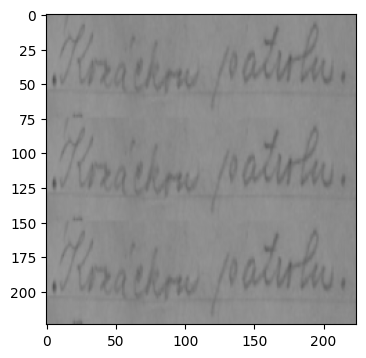

In [6]:
# for label, ids in labels_to_indices.items():
#     imgs = []
#     for img_id in ids:
#         imgs.append(dataset[img_id][0])
    
#     imshow(torchvision.utils.make_grid(imgs))

imshow(torchvision.utils.make_grid(dataset[0][0]))


In [7]:
inference_model.train_knn(dataset)

/home/jovyan/my-conda-envs/knn/lib/python3.11/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


query image


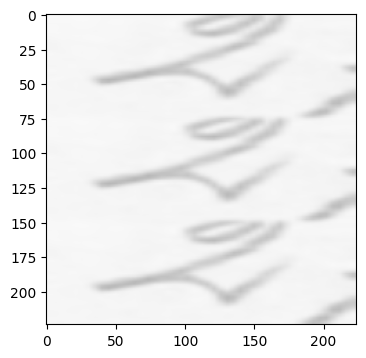

nearest images


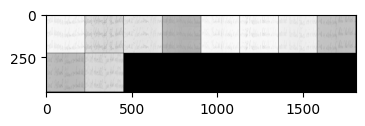

query image


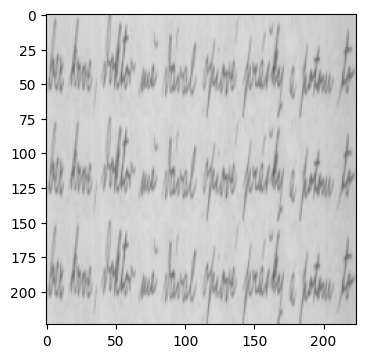

nearest images


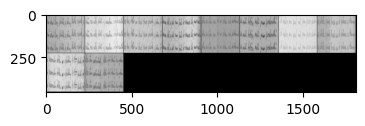

In [8]:
for img_type in [classA, classB]:
    img = dataset[img_type[0]][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    distances, indices = inference_model.get_nearest_neighbors(img, k=10)
    nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Different writer


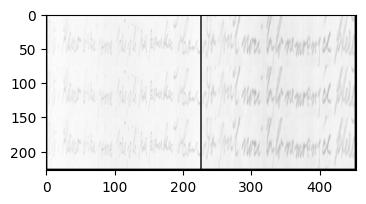

Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Different writer


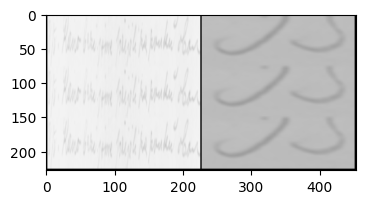

Same writer
Same writer
Different writer


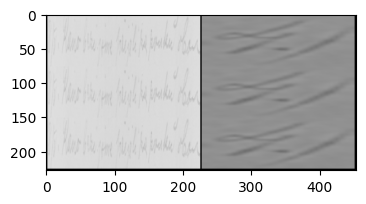

Same writer
Same writer
Different writer


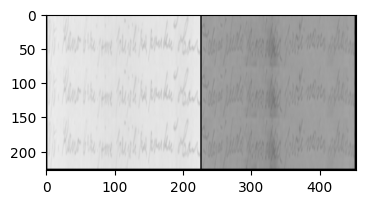

Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Different writer


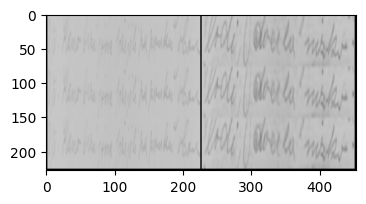

Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Same writer
Different writer


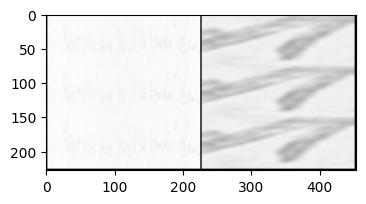

Same writer
Same writer
Same writer
Different writer


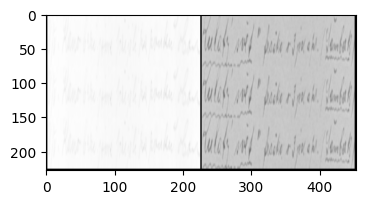

Same writer
Same writer
Same writer
Same writer
Same writer
Different writer


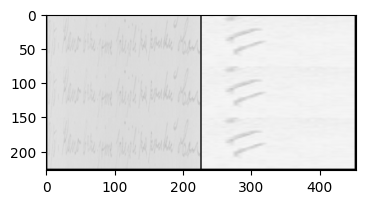

Different writer


In [9]:
for image_id in classA:
    (x, _), (y, _) = dataset[classA[3]], dataset[image_id]
    decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
    print_decision(decision)
    if not decision:
        imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))

print_decision(decision)

In [10]:
good = 0
wrong = 0

all_ids = labels_to_indices.values()
all_ids = [item for sublist in all_ids for item in sublist]

for target_writer, target_ids in labels_to_indices.items():
    print(target_writer, good, wrong)
    
    mask = np.isin(all_ids, target_ids, invert=True)
    non_target_ids = np.array(all_ids)[mask]
    picked_same = np.random.choice(target_ids, (100,2))
    
    picked_non_target = np.random.choice(non_target_ids, 100)
    picked_target = np.random.choice(target_ids, 100)
    picked_different = np.vstack((picked_non_target, picked_target)).T
    
    for a in picked_same:
        (x, _), (y, _) = dataset[a[0]], dataset[a[1]]
        decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
        if decision == True:
            good += 1
        else:
            wrong += 1

    for a in picked_different:
        (x, _), (y, _) = dataset[a[0]], dataset[a[1]]
        decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
        if decision == False:
            good += 1
        else:
            wrong += 1

print(good, wrong, good/(good+wrong))
                
                

15 0 0
0 195 5
1 378 22
14 532 68
19 712 88
12 910 90
8 1083 117
10 1283 117
4 1483 117
6 1677 123
17 1876 124
13 2055 145
20 2253 147
7 2440 160
16 2632 168
5 2832 168
9 3011 189
11 3190 210
18 3380 220
3 3556 244
2 3754 246
3935 265 0.9369047619047619
